In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
training_data = pd.read_csv('train_final.csv')
test_data = pd.read_csv('test_final.csv')

In [6]:
training_data.columns

Index(['Id', 'Y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24'],
      dtype='object')

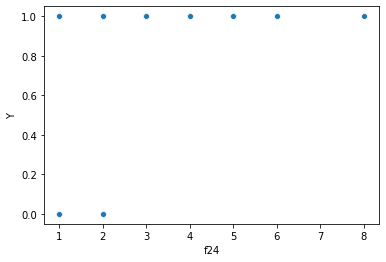

In [7]:
sns.scatterplot(data=training_data, x='f24', y="Y")

In [8]:
# this way is splitting training data to train/test to see how good it is
X = training_data.drop(['Y', 'Id'],axis=1)
y = training_data['Y']

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=4)
ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

In [25]:
# this way is having all train data as train and test on seperate test data to submit
fx_train = training_data.drop(['Y', 'Id'],axis=1)
fy_train = training_data['Y']
ros = RandomOverSampler()
fx_train, fy_train = ros.fit_resample(fx_train, fy_train)
fx_test = test_data.drop('Id',axis=1)

In [ ]:
#normalizing data - didnt work
n = x_train.nunique(axis=0)
nums = n[n>9].index
nums
x_train[nums] = x_train[nums].apply(lambda x: (x - x.mean()) / (x.std()))
x_test[nums] = x_test[nums].apply(lambda x: (x - x.mean()) / (x.std()))

In [ ]:
cf=lightgbm.LGBMClassifier(verbose=1)
parameters = {'n_estimators': np.linspace(400, 600, 20, dtype=int),               
                                                      #'max_depth': [10,20,30,40,50,60,70,80,90,100],              
                                                      'num_leaves': np.arange(40,60),
                                                      'learning_rate': [0.1], 'min_data_in_leaf':[1] }
#                                                     'bagging_fraction': [0.1,0.3,0.4,0.5,0.7,0.8,1],
#                                                     'min_data_in_leaf': [10,20,30,50,70,100]
#                                                      ,'max_bin':[100,200,300,400], 'extra_trees':[False]}         
                                                      #'min_gain_to_split':[1,10,100,1000]}
clf_GS = RandomizedSearchCV(cf,parameters,n_iter=100,n_jobs=-1).fit(x_train,y_train) 

In [ ]:
clf_GS.best_params_

In [ ]:
#only when working with training data
accuracy = clf_GS.score(x_test,y_test)
accuracy

In [ ]:
y = clf_GS.predict_proba(x_test)[:,1]
y

In [ ]:
score = metrics.roc_auc_score(y_test, y)
score

In [ ]:
finalcf = lightgbm.LGBMClassifier(num_leaves=51,n_estimators=500,max_depth=100, learning_rate=0.1).fit(fx_train,fy_train)

In [ ]:
y = finalcf.predict_proba(fx_test)[:,1]

In [26]:
#pipeline thing, didnt work
newcf = lightgbm.LGBMClassifier(num_leaves=50,n_estimators=514,max_depth=90,min_data_in_leaf=100,
                               extra_trees=True, metrics='auc') #done with best params
clf = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=105))),
    ('classification', newcf)])
clf.fit(fx_train, fy_train)
# clf.score(x_test,y_test)
y = clf.predict_proba(fx_test)[:,1]
# score = metrics.roc_auc_score(y_test, y)
# # score
# print("training score "+str(clf.score(x_train,y_train)))
# print("test score "+str(clf.score(x_test,y_test)))
# print("AUC score "+str(score))

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


In [ ]:
pipe = make_pipeline(SelectFromModel(RandomForestClassifier(n_estimators=100)),newcf)
pipe.fit(x_train, y_train)
y_proba = pipe.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
print("training score "+str(pipe.score(x_train,y_train)))
print("test score "+str(pipe.score(x_test,y_test)))
print("AUC score "+str(score))

In [ ]:
newcf.fit(x_train,y_train)
y_proba = newcf.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
print("training score "+str(newcf.score(x_train,y_train)))
print("test score "+str(newcf.score(x_test,y_test)))
print("AUC score "+str(score))

In [ ]:
y.shape
y

In [27]:
# making submission csv
y_series = pd.Series(y,name='Y')
x_series = test_data['Id']
submit = pd.concat([x_series, y_series], axis=1)
submit.to_csv('submission.csv',index=False)

In [16]:
y_two = y_probaAda*0.5+y*0.5

In [28]:
submit

,Id,Y
0,16384,0.634027
1,16385,0.584985
2,16386,0.999444
3,16387,0.999439
4,16388,0.984394
...,...,...
16380,32764,0.999120
16381,32765,0.976231
16382,32766,0.999266
16383,32767,0.575460


In [9]:
svm = LinearSVC(C=0.0001)
cl = CalibratedClassifierCV(svm)
cl.fit(x_train, y_train)
y_proba = cl.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
score

0.4715945476168695

In [10]:
lg = lightgbm.LGBMClassifier()
lg.fit(x_train,y_train)
y_proba = lg.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
score

0.8596923995103485

In [11]:
lg = RandomForestClassifier()
lg.fit(x_train,y_train)
y_proba = lg.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
score

0.866261745755845

In [12]:
lg = LogisticRegression()
lg.fit(x_train,y_train)
y_proba = lg.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
score

0.48591489472927585

In [ ]:
cfAda=AdaBoostClassifier()
parameters = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,200,500,1000], 'learning_rate': [0.01,0.1,0.5,1,3,5,10],
             'algorithm': ['SAMME', 'SAMME.R']} 
clf_GS = RandomizedSearchCV(cfAda,parameters,n_iter=100,n_jobs=-1).fit(fx_train,fy_train)
print(clf_GS.best_params_)
yprob = clf_GS.predict_proba(fx_test)[:,1]
# score = metrics.roc_auc_score(y_test, yprob)
# score

In [11]:
lg = AdaBoostClassifier(n_estimators=1000,algorithm='SAMME.R')
lg.fit(fx_train,fy_train)
y_probaAda = lg.predict_proba(fx_test)[:,1]
# score = metrics.roc_auc_score(y_test, y_probaAda)
# score

In [ ]:
y_both = y_probaAda*0.5+y_proba*0.5
score = metrics.roc_auc_score(y_test, y_both)
score

In [13]:
lg = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
lg.fit(x_train,y_train)
y_proba = lg.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
score

0.6377586026634604

In [14]:
lg = DecisionTreeClassifier()
lg.fit(x_train,y_train)
y_proba = lg.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, y_proba)
score

0.6722068298548035

In [12]:
model = xgboost.XGBClassifier(n_estimators=800,validate_parameters=True,booster='dart')
model.fit(fx_train, fy_train)
yx = model.predict(fx_test)
# score = metrics.roc_auc_score(y_test, yx)
# score

[00:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
cfx=xgboost.XGBClassifier()
parameters = {'booster': ['dart','gbtree'], 'n_estimators': [10,50,100,300,500,1000],'validate_parameters':[True], 'gamma':
             [0,10,50,100,500], 'max_depth':[1,2,3,4,5,6,7,8,9,10], 'eta':[0.1,0.3,0.5,0.8]} 
clf_GS = RandomizedSearchCV(cfx,parameters,n_iter=100,n_jobs=-1).fit(x_train,y_train)
print(clf_GS.best_params_)
yprob = clf_GS.predict_proba(x_test)[:,1]
score = metrics.roc_auc_score(y_test, yprob)
score

In [13]:
y_both = yx*(1/3)+y*(1/3)+(1/3)*y_probaAda #switch with yprob when above finishes
# score = metrics.roc_auc_score(y_test, y_both)
# score